This notebook shows;
Thresholded Movement Classifier (direction-agnostic) — SMOTE & Robust Mentions
- Compare Logistic, Random Forest, Extra Trees, XGBoost
- Label = 1 if |next-day log return| >= k * rolling_std_20 (computed at t)
- Features: mentions (levels & 1-day changes, if present), recent return stats, rolling std, variance controls
- Models: Logistic Regression & RandomForest trained on SMOTE-resampled training data
- Robust to missing mention columns (fills with 0).

In [ ]:


import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             precision_recall_curve, confusion_matrix, f1_score)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import os
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


In [230]:



ROLL_WIN = int(os.getenv("ROLL_WIN", 20))   # rolling window for volatility
K_SIGMA  = float(os.getenv("K_SIGMA", 1.5)) # threshold multiplier

DATA_DIR = Path(os.getenv("DATA_DIR", "/users/nihan/Desktop/Erdos_FinanceProject/classification"))
DATA_STOCK    = DATA_DIR / os.getenv("DATA_STOCK", "bluesky_stock_merged.csv")
DATA_MENTIONS = DATA_DIR / os.getenv("DATA_MENTIONS", "bluesky_merged_mentions.csv")
DATA_CONTROLS = DATA_DIR / os.getenv("DATA_CONTROLS", "control_sa.csv")

OUT_DATASET = DATA_DIR / "movement_threshold_dataset_smote_xgb.csv"
OUT_RESULTS = DATA_DIR / "model_results_smote_xgb.csv"
OUT_ROC_PNG = DATA_DIR / "roc_comparison_smote_xgb.png"

MENTION_COLS = ["all_keywords_mentions","ticker_mentions","ceo_mentions"]


In [231]:

def safe_read_csv(path: Path) -> pd.DataFrame:
    if path.exists():
        return pd.read_csv(path)
    print(f"[WARN] Missing file: {path} — continuing without it.")
    return pd.DataFrame()

def ensure_mention_cols(df: pd.DataFrame) -> pd.DataFrame:
    for c in MENTION_COLS:
        if c not in df.columns:
            df[c] = 0
    return df

def build_dataset():
    stock = safe_read_csv(DATA_STOCK)
    assert not stock.empty, f"Cannot proceed: {DATA_STOCK} is missing or empty."
    stock["Date"] = pd.to_datetime(stock["Date"])

    mentions = safe_read_csv(DATA_MENTIONS)
    if not mentions.empty:
        if "date" in mentions.columns:
            mentions["date"] = pd.to_datetime(mentions["date"])
            mentions = mentions.rename(columns={"date": "Date"})
        elif "Date" in mentions.columns:
            mentions["Date"] = pd.to_datetime(mentions["Date"])
        else:
            print("[WARN] Mentions has no date column; skipping merge.")
            mentions = pd.DataFrame()

    controls = safe_read_csv(DATA_CONTROLS)

    df = stock.copy()
    if not mentions.empty and {"company","Date"}.issubset(mentions.columns) and "company" in df.columns:
        keep = ["company","Date"] + [c for c in MENTION_COLS if c in mentions.columns]
        keep = [c for c in keep if c in mentions.columns]
        df = df.merge(mentions[keep], on=["company","Date"], how="left")
    else:
        print("[INFO] Mentions merge skipped or partial; filling missing mention columns with zeros.")
    df = ensure_mention_cols(df)

    if not controls.empty and "Ticker" in controls.columns:
        df = df.merge(controls, on="Ticker", how="left", suffixes=("","_ctrl"))

    # Target construction
    df = df.sort_values(["Ticker","Date"]).reset_index(drop=True)
    df["log_ret_t"]   = df["log_return"]
    df["log_ret_tp1"] = df.groupby("Ticker")["log_return"].shift(-1)
    df["roll_std_20"] = df.groupby("Ticker")["log_ret_t"].transform(
        lambda s: s.rolling(ROLL_WIN, min_periods=20).std()
    )
    df["label_big_move"] = (df["log_ret_tp1"].abs() >= (K_SIGMA * df["roll_std_20"])).astype(int)

    # Feature engineering
    for col in MENTION_COLS:
        df[f"{col}_lag1"] = df.groupby("Ticker")[col].shift(1)
        df[f"{col}_chg1"]  = df[col] - df[f"{col}_lag1"]

    df["ret_lag1"] = df.groupby("Ticker")["log_ret_t"].shift(1)
    df["ret_lag5"] = df.groupby("Ticker")["log_ret_t"].shift(5)
    df["ret_ma5"]  = df.groupby("Ticker")["log_ret_t"].transform(lambda s: s.rolling(5, min_periods=3).mean())
    df["ret_std5"] = df.groupby("Ticker")["log_ret_t"].transform(lambda s: s.rolling(5, min_periods=3).std())

    df_model = df.dropna(subset=["log_ret_tp1","roll_std_20"]).copy()

    candidate_feats = [
        "all_keywords_mentions","ticker_mentions","ceo_mentions",
        "all_keywords_mentions_chg1","ticker_mentions_chg1","ceo_mentions_chg1",
        "ret_lag1","ret_lag5","ret_ma5","ret_std5",
        "roll_std_20",
        "weekly_variance","monthly_variance",
        "weekly_variance_ctrl","pct_change","monthly_variance_ctrl"
    ]
    feature_cols = [c for c in candidate_feats if c in df_model.columns]

    return df_model, feature_cols



In [ ]:

    df_model, feature_cols = build_dataset()

    X = df_model[feature_cols].copy()
    y = df_model["label_big_move"].astype(int).copy()

    # Time-based split
    cutoff_date = df_model["Date"].quantile(0.80)
    train_idx = df_model["Date"] <= cutoff_date
    test_idx  = df_model["Date"] >  cutoff_date

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]

    X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

    # Scale
    scaler = StandardScaler(with_mean=False)
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # SMOTE
    sm = SMOTE(random_state=42, sampling_strategy=0.5)
    X_train_res, y_train_res = sm.fit_resample(X_train_s, y_train)


In [234]:

    # Models
    models = {
        "Logistic": LogisticRegression(max_iter=3000, n_jobs=1),
        "RandomForest": RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_split=4, min_samples_leaf=2,
            n_jobs=-1, random_state=42),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
            tree_method="hist"  # fast & safe default
        )
    }

In [238]:


    results = []
    roc_curves = []

    for name, model in models.items():
        model.fit(X_train_res, y_train_res)
        yhat = model.predict(X_test_s)
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test_s)[:,1]
        else:
            # Fallback: decision_function → map to [0,1] with min-max (rarely needed here)
            if hasattr(model, "decision_function"):
                s = model.decision_function(X_test_s)
                proba = (s - s.min()) / (s.max() - s.min() + 1e-9)
            else:
                proba = np.zeros_like(yhat, dtype=float)

        auc = roc_auc_score(y_test, proba)
        f1_pos = f1_score(y_test, yhat, pos_label=1)
        f1_macro = f1_score(y_test, yhat, average='macro')

        print(f"\n=== {name} (SMOTE) ===")
        print(classification_report(y_test, yhat, digits=3))
        print(f"ROC-AUC: {auc:.3f} | F1 (positive): {f1_pos:.3f} | F1 (macro): {f1_macro:.3f}")
        print("Confusion matrix:\n", confusion_matrix(y_test, yhat))

        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_curves.append((name, fpr, tpr, auc))

        results.append({
            "Model": name,
            "ROC-AUC": auc,
            "F1_Positive": f1_pos,
            "F1_Macro": f1_macro
        })
    # Summary table
    result_df = pd.DataFrame(results).sort_values("F1_Positive", ascending=False)
    print("\n=== MODEL COMPARISON TABLE (sorted by F1_Positive) ===")
    print(result_df.to_string(index=False))
    result_df.to_csv(OUT_RESULTS, index=False)


=== Logistic (SMOTE) ===
              precision    recall  f1-score   support

           0      0.876     0.831     0.853      1790
           1      0.203     0.268     0.231       287

    accuracy                          0.753      2077
   macro avg      0.540     0.550     0.542      2077
weighted avg      0.783     0.753     0.767      2077

ROC-AUC: 0.649 | F1 (positive): 0.231 | F1 (macro): 0.542
Confusion matrix:
 [[1488  302]
 [ 210   77]]

=== RandomForest (SMOTE) ===
              precision    recall  f1-score   support

           0      0.879     0.917     0.898      1790
           1      0.294     0.216     0.249       287

    accuracy                          0.820      2077
   macro avg      0.587     0.566     0.573      2077
weighted avg      0.799     0.820     0.808      2077

ROC-AUC: 0.686 | F1 (positive): 0.249 | F1 (macro): 0.573
Confusion matrix:
 [[1641  149]
 [ 225   62]]

=== XGBoost (SMOTE) ===
              precision    recall  f1-score   support

  

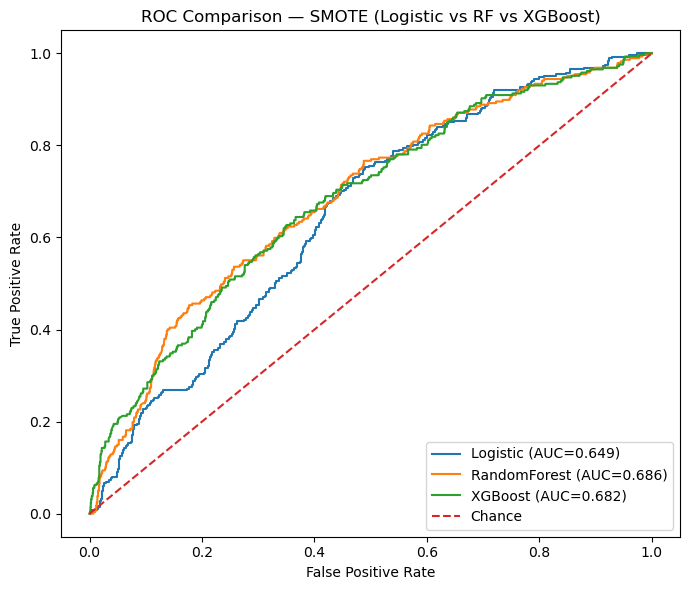


Best model: XGBoost (ROC-AUC=0.682, F1_Positive=0.311)
Saved dataset: /users/nihan/Desktop/Erdos_FinanceProject/classification/movement_threshold_dataset_smote_xgb.csv
Saved results table: /users/nihan/Desktop/Erdos_FinanceProject/classification/model_results_smote_xgb.csv
Saved ROC plot: /users/nihan/Desktop/Erdos_FinanceProject/classification/roc_comparison_smote_xgb.png


In [237]:

    # Save dataset for reproducibility
    keep_cols = ["Date","Ticker","company","log_ret_tp1","roll_std_20","label_big_move"] + feature_cols
    df_model[keep_cols].to_csv(OUT_DATASET, index=False)

    # Combined ROC plot
    plt.figure(figsize=(7,6))
    for name, fpr, tpr, auc in roc_curves:
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Comparison — SMOTE (Logistic vs RF vs XGBoost)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(OUT_ROC_PNG, dpi=150)
    plt.show()

    # Best model (by F1_Positive)
    best_row = result_df.iloc[0]
    print(f"\nBest model: {best_row['Model']} "
          f"(ROC-AUC={best_row['ROC-AUC']:.3f}, F1_Positive={best_row['F1_Positive']:.3f})")
    print(f"Saved dataset: {OUT_DATASET}")
    print(f"Saved results table: {OUT_RESULTS}")
    print(f"Saved ROC plot: {OUT_ROC_PNG}")

In [202]:
# --- Build dataset ---
df_model, feature_cols = build_dataset()

# --- Define X and y ---
X = df_model[feature_cols].values
y = df_model["label_big_move"].values


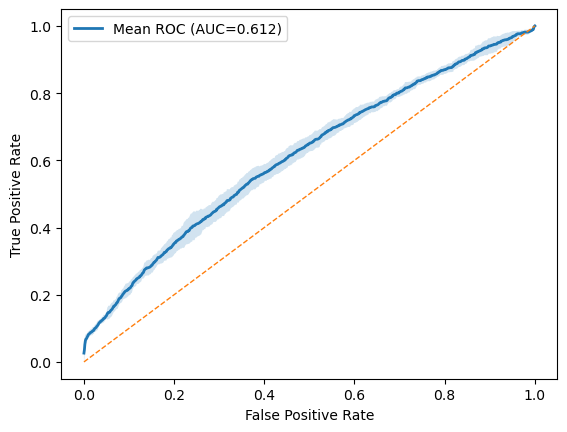

In [203]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import numpy as np, matplotlib.pyplot as plt

model = LogisticRegression(max_iter=2000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 1001)
tprs, aucs = [], []

for tr, te in cv.split(X, y):
    model.fit(X[tr], y[tr])
    y_score = model.predict_proba(X[te])[:, 1]
    fpr, tpr, _ = roc_curve(y[te], y_score)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(auc(fpr, tpr))

mean_tpr = np.mean(tprs, axis=0)
std_tpr  = np.std(tprs, axis=0)

plt.plot(mean_fpr, mean_tpr, lw=2, label=f"Mean ROC (AUC={np.mean(aucs):.3f})")
plt.fill_between(mean_fpr,
                 np.maximum(mean_tpr - std_tpr, 0),
                 np.minimum(mean_tpr + std_tpr, 1),
                 alpha=0.2)
plt.plot([0,1], [0,1], "--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [204]:

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler



# === Preprocess (scale + balance) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply SMOTE *inside* each fold to avoid leakage
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 1001)

models = {
    "Logistic": LogisticRegression(max_iter=2000, solver="lbfgs"),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=400, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=42, use_label_encoder=False
    ),
}


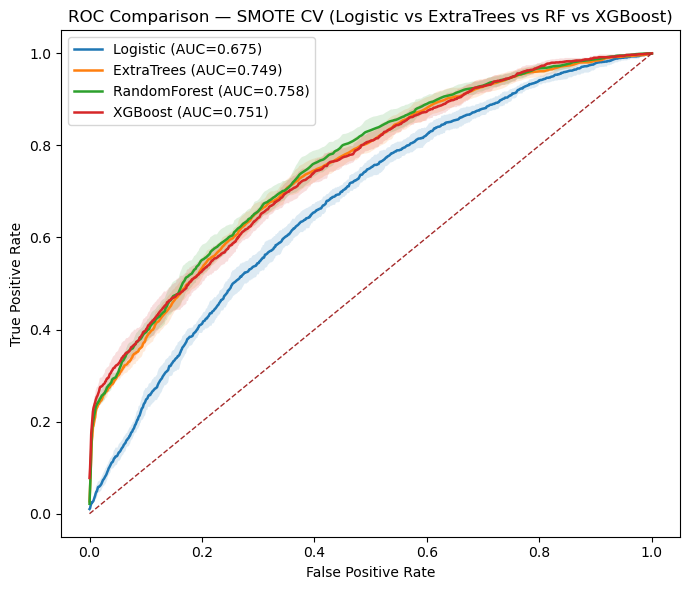

In [205]:

plt.figure(figsize=(7,6))
for name, model in models.items():
    tprs, aucs = [], []
    for tr, te in cv.split(X_scaled, y):
        X_tr, X_te = X_scaled[tr], X_scaled[te]
        y_tr, y_te = y[tr], y[te]

        # SMOTE balancing within train fold
        X_res, y_res = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

        model.fit(X_res, y_res)
        y_score = model.predict_proba(X_te)[:, 1]

        fpr, tpr, _ = roc_curve(y_te, y_score)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr  = np.std(tprs, axis=0)
    mean_auc = np.mean(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=1.8, label=f"{name} (AUC={mean_auc:.3f})")
    plt.fill_between(mean_fpr,
                     np.maximum(mean_tpr - std_tpr, 0),
                     np.minimum(mean_tpr + std_tpr, 1),
                     alpha=0.15)

# --- Chance line ---
plt.plot([0,1],[0,1],'--',lw=1,color='brown')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison — SMOTE CV (Logistic vs ExtraTrees vs RF vs XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()


In [206]:
from sklearn.metrics import (
    roc_curve, auc, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE

# --- Collect per-model CV metrics ---
rows = []
for name, model in models.items():
    aucs, ap_aucs = [], []
    accs, precs, recs, f1s = [], [], [], []

    for tr, te in cv.split(X_scaled, y):
        X_tr, X_te = X_scaled[tr], X_scaled[te]
        y_tr, y_te = y[tr], y[te]

        # Balance only on the training fold
        X_res, y_res = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

        # Fit + predict
        model.fit(X_res, y_res)
        y_score = model.predict_proba(X_te)[:, 1]     # keep probabilities
        y_pred  = (y_score >= 0.5).astype(int)        # fixed 0.5 threshold for comparability

        # Metrics per fold
        fpr, tpr, _ = roc_curve(y_te, y_score)
        aucs.append(auc(fpr, tpr))
        ap_aucs.append(average_precision_score(y_te, y_score))
        accs.append(accuracy_score(y_te, y_pred))
        precs.append(precision_score(y_te, y_pred, zero_division=0))
        recs.append(recall_score(y_te, y_pred, zero_division=0))
        f1s.append(f1_score(y_te, y_pred, zero_division=0))

    rows.append({
        "Model": name,
        "AUC_mean":  np.mean(aucs), "AUC_std":  np.std(aucs),
        "AP_mean":   np.mean(ap_aucs), "AP_std": np.std(ap_aucs),
        "Acc_mean":  np.mean(accs), "Acc_std":  np.std(accs),
        "Prec_mean": np.mean(precs), "Prec_std": np.std(precs),
        "Rec_mean":  np.mean(recs), "Rec_std":  np.std(recs),
        "F1_mean":   np.mean(f1s),  "F1_std":   np.std(f1s),
    })






In [207]:
# --- Summary table ---
results_df = (
    pd.DataFrame(rows)
      .sort_values("AUC_mean", ascending=False)
      .reset_index(drop=True)
)

# Pretty rounding for display
display_cols = ["Model",
                "AUC_mean","AUC_std",
                "Acc_mean","Acc_std",
                "Prec_mean","Prec_std",
                "Rec_mean","Rec_std",
                "F1_mean","F1_std"]
print(results_df[display_cols].round(3))

          Model  AUC_mean  AUC_std  Acc_mean  Acc_std  Prec_mean  Prec_std  \
0  RandomForest     0.758    0.015     0.831    0.005      0.466     0.017   
1       XGBoost     0.751    0.015     0.806    0.008      0.404     0.021   
2    ExtraTrees     0.749    0.013     0.836    0.003      0.482     0.013   
3      Logistic     0.675    0.015     0.679    0.013      0.260     0.011   

   Rec_mean  Rec_std  F1_mean  F1_std  
0     0.366    0.019    0.410   0.015  
1     0.440    0.028    0.421   0.022  
2     0.326    0.020    0.388   0.016  
3     0.541    0.020    0.351   0.012  



Top 15 Features (average importance across models):


,Logistic,ExtraTrees,RandomForest,XGBoost,Mean
roll_std_20,1.0034,0.1558,0.1531,0.1262,0.3596
monthly_variance_ctrl,0.9558,0.0767,0.0727,0.1542,0.3148
weekly_variance_ctrl,0.6877,0.0756,0.0732,0.1318,0.2421
weekly_variance,0.5398,0.0891,0.0891,0.0651,0.1958
ret_ma5,0.1526,0.1206,0.1300,0.1012,0.1261
monthly_variance,0.2217,0.1040,0.1049,0.0720,0.1257
ret_lag1,0.1670,0.1143,0.1171,0.0910,0.1224
ret_std5,0.0740,0.0861,0.0831,0.0661,0.0773
pct_change,0.0145,0.0764,0.0722,0.1319,0.0738
ret_lag5,0.0274,0.1013,0.1045,0.0605,0.0734


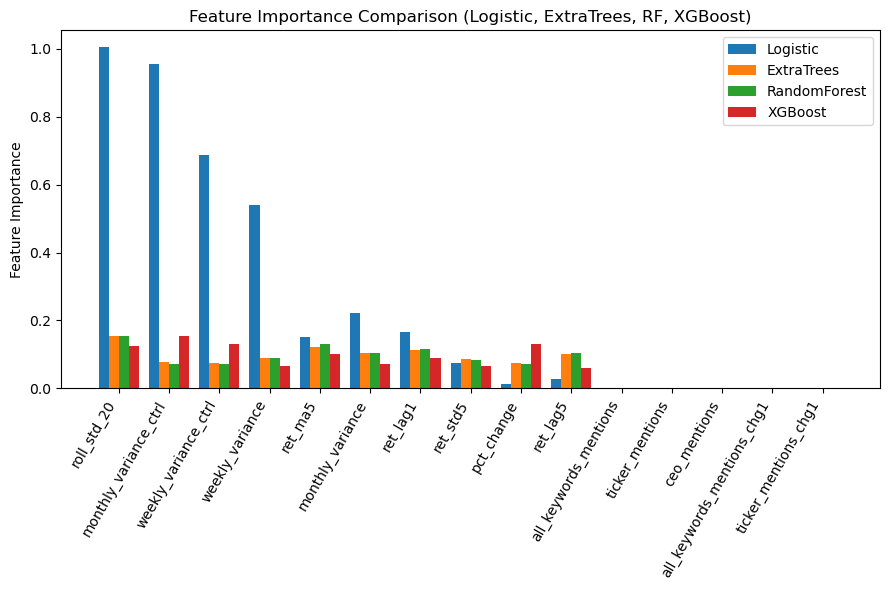

In [208]:

from sklearn.inspection import permutation_importance

# --- Fit models once on full SMOTE-balanced data for feature importance ---
X_res, y_res = SMOTE(random_state=42).fit_resample(X_scaled, y)

feat_imps = {}

for name, model in models.items():
    model.fit(X_res, y_res)

    if hasattr(model, "feature_importances_"):  # tree-based models
        imp = model.feature_importances_
    elif name == "Logistic":
        imp = np.abs(model.coef_[0])  # absolute value of logistic weights
    else:
        # fallback to permutation importance
        perm = permutation_importance(model, X_res, y_res, n_repeats=5, random_state=42, n_jobs=-1)
        imp = perm.importances_mean

    feat_imps[name] = imp

# --- Combine into a DataFrame ---
imp_df = pd.DataFrame(feat_imps, index=feature_cols)
imp_df["Mean"] = imp_df.mean(axis=1)
imp_df = imp_df.sort_values("Mean", ascending=False).round(4)

# --- Show top features ---
print("\nTop 15 Features (average importance across models):")
display(imp_df.head(15))

# --- Plot comparative importance ---
top_feats = imp_df.head(15).index
plt.figure(figsize=(9,6))
bar_width = 0.2
positions = np.arange(len(top_feats))

for i, name in enumerate(models.keys()):
    plt.bar(positions + i*bar_width, imp_df.loc[top_feats, name], width=bar_width, label=name)

plt.xticks(positions + bar_width*1.5, top_feats, rotation=60, ha="right")
plt.ylabel("Feature Importance")
plt.title("Feature Importance Comparison (Logistic, ExtraTrees, RF, XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()


In [209]:
# Logistic shares
logi_coef = pd.Series(logi_clf.coef_.ravel(), index=feature_cols).abs()
logistic = logi_coef.groupby(lambda f: "Mentions (levels+deltas)"
                                        if "mentions" in f.lower()
                                        else "Market/Vol/Controls").sum()
logistic = logistic / logistic.sum()

# RF permutation importance (uses the now-fitted rf)
pi = permutation_importance(
    rf,
    X_te.values if hasattr(X_te, "values") else X_te,
    y_te.values if hasattr(y_te, "values") else y_te,
    scoring="roc_auc", n_repeats=5, random_state=42, n_jobs=1
)
pi

{'importances_mean': array([-3.39553962e-07, -1.69776981e-07, -1.69776981e-07,  0.00000000e+00,
        -2.22044605e-17,  0.00000000e+00,  3.62361802e-02,  3.08814142e-02,
         6.65826271e-02,  4.90146144e-02,  1.68373095e-01,  3.99346019e-02,
         5.98754177e-02,  8.78765653e-03,  1.40329164e-02,  1.34045718e-02]),
 'importances_std': array([4.15866973e-07, 3.39553962e-07, 3.39553962e-07, 0.00000000e+00,
        4.44089210e-17, 0.00000000e+00, 3.36745126e-03, 2.39026107e-03,
        5.75267617e-03, 5.56123747e-03, 1.40611934e-02, 5.60118459e-03,
        5.10053941e-03, 3.29023527e-03, 3.71977584e-03, 4.01240284e-03]),
 'importances': array([[-8.48884905e-07,  0.00000000e+00, -8.48884905e-07,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -8.48884905e-07],
        [ 0.00000000e+00,  0.00000000e+00, -1.11022302e-16,
          0.00000000e+00, -8.48884905e-07],
        [ 0.00000000e+00,  0.00000000e

In [210]:
# === Extract X_test, y_test, train/test masks from main() results ===
cutoff_date = df_model["Date"].quantile(0.80)
train_idx = df_model["Date"] <= cutoff_date
test_idx  = df_model["Date"] >  cutoff_date

X_test = df_model.loc[test_idx, feature_cols]
y_test = df_model.loc[test_idx, "label_big_move"].astype(int)
X_train = df_model.loc[train_idx, feature_cols]
y_train = df_model.loc[train_idx, "label_big_move"].astype(int)


In [211]:
# === Per-Ticker ROC-AUC on TEST (Logistic vs RandomForest) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

_logi = logit
if hasattr(_logi, "named_steps"):  # pipeline case
    _base = _logi.named_steps.get("clf", None)
    if _base is None or not hasattr(_base, "coef_"):
        logit.fit(X_train, y_train)
elif not hasattr(_logi, "coef_"):
    logit.fit(X_train, y_train)

if not hasattr(rf, "classes_"):
    rf.fit(X_train, y_train)


In [212]:

# --- Predict test probabilities ---
p_logi = logit.predict_proba(X_test)[:, 1]
p_rf   = rf.predict_proba(X_test)[:, 1]

# --- Build frame with tickers and true labels on TEST ---
test_tick = df_model.loc[test_idx, "Ticker"].reset_index(drop=True)
y_true    = (y_test.reset_index(drop=True)
             if hasattr(y_test, "reset_index")
             else pd.Series(y_test, name="label_big_move"))

pred_df = pd.DataFrame({
    "Ticker": test_tick.values,
    "y":      y_true.values,
    "p_logi": p_logi,
    "p_rf":   p_rf,
})
pred_df

,Ticker,y,p_logi,p_rf
0,AAPL,1,0.095361,0.202010
1,AAPL,0,0.095370,0.198310
2,AAPL,0,0.095529,0.190776
3,AAPL,0,0.095576,0.193810
4,AAPL,0,0.095457,0.193810
...,...,...,...,...
2072,WMT,0,0.095912,0.200367
2073,WMT,0,0.095948,0.202033
2074,WMT,0,0.095974,0.199367
2075,WMT,0,0.096037,0.201700


In [213]:

# ---  per-ticker AUC (skip tickers with 1 class in test) ---
def safe_auc(y, p):
    y = np.asarray(y)
    if len(np.unique(y)) < 2:
        return np.nan
    try:
        return roc_auc_score(y, p)
    except Exception:
        return np.nan

rows = []
for tkr, g in pred_df.groupby("Ticker"):
    rows.append({
        "Ticker": tkr,
        "Support": len(g),
        "Positives": int(np.sum(g["y"])),
        "AUC_Logistic": safe_auc(g["y"], g["p_logi"]),
        "AUC_RF":       safe_auc(g["y"], g["p_rf"]),
    })


In [214]:

auc_df = (pd.DataFrame(rows)
          .sort_values(["AUC_Logistic","AUC_RF"], ascending=[False, False])
          .reset_index(drop=True))

# --- Show table ---
display(auc_df.round(4))


,Ticker,Support,Positives,AUC_Logistic,AUC_RF
0,IBM,46,3,0.8140,0.2248
1,JNJ,46,4,0.7917,0.2500
2,CVS,46,6,0.7875,0.4708
3,UNH,46,5,0.7805,0.7854
4,MSFT,46,7,0.7509,0.3297
5,AMZN,46,5,0.7366,0.4683
6,CVX,46,9,0.7237,0.5405
7,WFC,46,5,0.7171,0.4683
8,WBA,375,77,0.7048,0.3694
9,ABBV,46,7,0.6960,0.4762


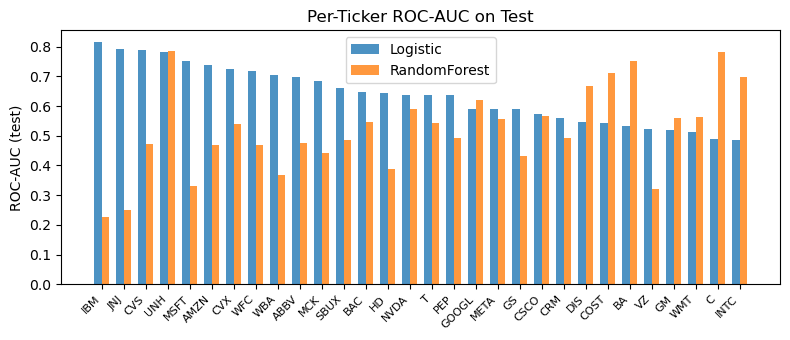

In [215]:

# --- Bar chart,  ---
topn = min(30, len(auc_df))  # chance for top N tickers for readability here rather than using 30
plot_df = auc_df.head(topn).sort_values("AUC_Logistic", ascending=False)

plt.figure(figsize=(8, 3.5))
bar_w = 0.35
x = np.arange(len(plot_df))

plt.bar(x - bar_w/2, plot_df["AUC_Logistic"], width=bar_w, label="Logistic", alpha=0.8)
plt.bar(x + bar_w/2, plot_df["AUC_RF"], width=bar_w, label="RandomForest", alpha=0.8)

plt.xticks(x, plot_df["Ticker"], rotation=45, ha="right", fontsize=8)
plt.ylabel("ROC-AUC (test)")
plt.title("Per-Ticker ROC-AUC on Test")
plt.legend()
plt.tight_layout()
plt.show()


In [216]:
print(hasattr(logit, "predict_proba"), hasattr(rf, "predict_proba"))


True True


In [217]:
# ===  Time-based comparison AFTER cutoff (per-model) ===
# Builds test split from df_model, scores available models, and plots:
# 1) Daily mean predicted probability (7d rolling) vs actual daily spike rate
# 2) Test ROC-AUC bar chart per model
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ---- Recreate the same 80/20 time split your main code uses ----
assert {"Date","Ticker","label_big_move"}.issubset(df_model.columns), "df_model missing required columns"
assert isinstance(feature_cols, (list, tuple)) and len(feature_cols) > 0, "feature_cols not set"

cutoff_date = df_model["Date"].quantile(0.80)
mask_tr = df_model["Date"] <= cutoff_date
mask_te = df_model["Date"] >  cutoff_date

X_train = df_model.loc[mask_tr, feature_cols]
y_train = df_model.loc[mask_tr, "label_big_move"].astype(int)
X_test  = df_model.loc[mask_te,  feature_cols]
y_test  = df_model.loc[mask_te,  "label_big_move"].astype(int)
test_meta = df_model.loc[mask_te, ["Date","Ticker"]].reset_index(drop=True)



In [218]:

# ---- without changing hyperparams/pipelines ----
models = []
if "logit" in globals(): models.append(("Logistic", logit))
if "rf"    in globals(): models.append(("RandomForest", rf))
if "xgb"   in globals(): models.append(("XGBoost", xgb))
if "extra" in globals(): models.append(("ExtraTrees", extra))


In [219]:

# --- Verify models are fitted; do NOT refit here ---
def _assert_fitted(name, mdl):
    base = mdl.named_steps["clf"] if hasattr(mdl, "named_steps") else mdl
    assert hasattr(base, "predict_proba"), f"{name} not fitted yet – run main() first."
    return mdl

models = [
    ("Logistic", _assert_fitted("Logistic", logit)),
    ("RandomForest", _assert_fitted("RandomForest", rf)),
    ("XGBoost", xgb) if "xgb" in globals() else None,
    ("ExtraTrees", extra) if "extra" in globals() else None,
]
models = [m for m in models if m]


In [220]:

# ---- Score test set and compute AUC per model ----
probs = {}
auc_rows = []
for name, mdl in models:
    mdl = _ensure_fitted(name, mdl)
    if hasattr(mdl, "predict_proba"):
        p = mdl.predict_proba(X_test)[:, 1]
    else:
        # decision_function → min-max to [0,1] for AUC comparability
        s = mdl.decision_function(X_test).astype(float)
        p = (s - s.min()) / (s.max() - s.min() + 1e-12)
    probs[name] = p
    try:
        auc = roc_auc_score(y_test, p)
    except Exception:
        auc = np.nan
    auc_rows.append({"Model": name, "AUC_test": auc})


In [221]:

auc_df = pd.DataFrame(auc_rows).sort_values("AUC_test", ascending=False).reset_index(drop=True)
display(auc_df.round(4))

# ---- Build time-series frame for the TEST period only ----
ts = test_meta.copy()
ts["y"] = y_test.values
for name, p in probs.items():
    ts[name] = p

# Daily means per model + actual event rate
daily = (ts.groupby("Date")
           .agg({**{k: "mean" for k in probs.keys()}, **{"y": "mean"}})
           .reset_index())


# 7-day rolling smooth for readability
roll = daily.copy()
for name in probs.keys():
    roll[name] = roll[name].rolling(7, min_periods=1).mean()
roll["y"] = roll["y"].rolling(7, min_periods=1).mean()


,Model,AUC_test
0,XGBoost,0.6614
1,Logistic,0.6231
2,RandomForest,0.4870


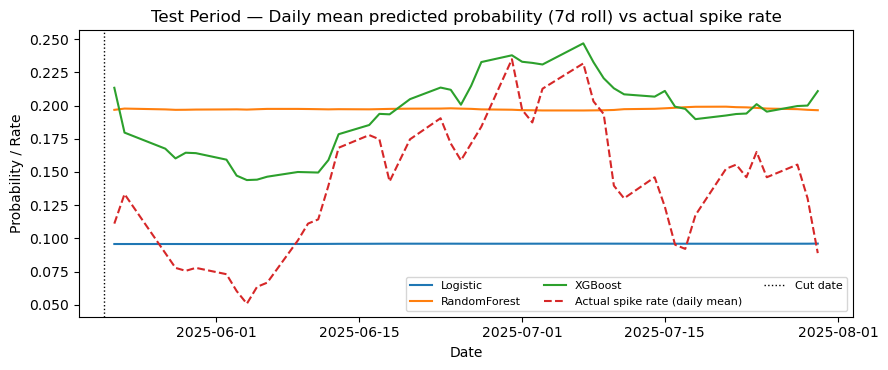

In [222]:

# ---- Plot: Daily mean probabilities (7d roll) vs actual spike rate (test only) ----
plt.figure(figsize=(9, 3.8))
for name in probs.keys():
    plt.plot(roll["Date"], roll[name], label=name)
plt.plot(roll["Date"], roll["y"], linestyle="--", label="Actual spike rate (daily mean)")
plt.axvline(pd.to_datetime(cutoff_date), color="k", ls=":", lw=1, label="Cut date")
plt.title("Test Period — Daily mean predicted probability (7d roll) vs actual spike rate")
plt.ylabel("Probability / Rate")
plt.xlabel("Date")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


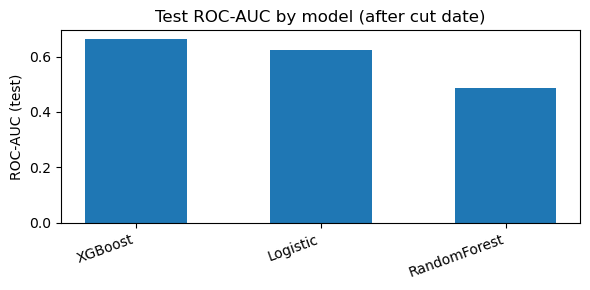

In [223]:

# ---- Plot : Test AUC bar chart per model (compact) ----
plt.figure(figsize=(6, 3))
x = np.arange(len(auc_df))
plt.bar(x, auc_df["AUC_test"].values, width=0.55)
plt.xticks(x, auc_df["Model"].values, rotation=20, ha="right")
plt.ylabel("ROC-AUC (test)")
plt.title("Test ROC-AUC by model (after cut date)")
plt.tight_layout()
plt.show()

In [224]:
# Check class balance in the TRAIN and TEST slices used by the add-on cell
cutoff_date = df_model["Date"].quantile(0.80)
mask_tr = df_model["Date"] <= cutoff_date
mask_te = df_model["Date"] >  cutoff_date

y_tr_chk = df_model.loc[mask_tr, "label_big_move"].astype(int)
y_te_chk = df_model.loc[mask_te, "label_big_move"].astype(int)

print("Train counts:", y_tr_chk.value_counts().to_dict())
print("Test  counts:", y_te_chk.value_counts().to_dict())
print("Train positives %:", round(100*y_tr_chk.mean(), 2), "%")
print("Test  positives %:", round(100*y_te_chk.mean(), 2), "%")


Train counts: {0: 6979, 1: 1389}
Test  counts: {0: 1790, 1: 287}
Train positives %: 16.6 %
Test  positives %: 13.82 %


In [225]:
# ---- How variable are the raw predictions? ----
def stats(name, p):
    print(f"{name:12s} min={p.min():.4f} max={p.max():.4f} std={p.std():.4f} "
          f"uniq≈{np.unique(np.round(p,4)).size}")

p_logi = logit.predict_proba(X_test)[:,1]
p_rf   = rf.predict_proba(X_test)[:,1]

stats("Logistic",     p_logi)
stats("RandomForest", p_rf)


Logistic     min=0.0927 max=0.0965 std=0.0004 uniq≈34
RandomForest min=0.1202 max=0.2111 std=0.0126 uniq≈304


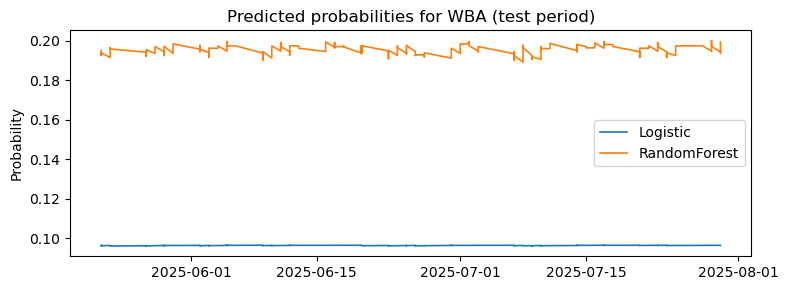

In [226]:
# --- visualize variation within a single ticker for Logistic & RF ---
ticker_example = df_model.loc[test_idx, "Ticker"].value_counts().index[0]  # most frequent ticker
mask_t = (df_model.loc[test_idx, "Ticker"] == ticker_example).values

plt.figure(figsize=(8,3))
plt.plot(df_model.loc[test_idx, "Date"].values[mask_t],
         logit.predict_proba(X_test)[mask_t,1],
         label="Logistic", lw=1.2)
plt.plot(df_model.loc[test_idx, "Date"].values[mask_t],
         rf.predict_proba(X_test)[mask_t,1],
         label="RandomForest", lw=1.2)
plt.title(f"Predicted probabilities for {ticker_example} (test period)")
plt.ylabel("Probability")
plt.legend(); plt.tight_layout(); plt.show()


In [227]:
probs = logit.predict_proba(X_test)[:,1]
uniq = np.unique(np.round(probs,6))
print("Unique probs:", len(uniq))
print("First 10:", uniq[:10])


Unique probs: 992
First 10: [0.092699 0.092754 0.092802 0.092914 0.09293  0.092951 0.092973 0.093062
 0.093085 0.093423]


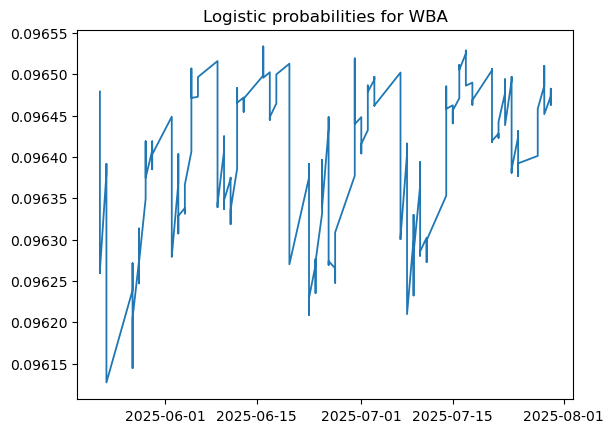

In [228]:
ticker_ex = df_model.loc[test_idx,"Ticker"].value_counts().index[0]
m = (df_model.loc[test_idx,"Ticker"]==ticker_ex).values
p = logit.predict_proba(X_test)[m,1]
plt.plot(df_model.loc[test_idx,"Date"].values[m], p, lw=1.3)
plt.title(f"Logistic probabilities for {ticker_ex}"); plt.show()
